# Оценка настроений и активности жителей различных районов Москвы #

*Датасет:* `geo.xlsx`

Каждая запись соответствует отзыву одного жителя Москвы

*Поля:*
- `x`, географическая широта
- `y`, георгафическая долгота
- `comment_class`, положительный или отрицательный отзыв (1 или -1 соответственно)

*Задачи:*

- провести кластеризацию отзывов
- выделить участки с наибольшей концентрацией положительных и отрицательных оценок
- оценить степень активности жителей в различных районах
- интерпретировать результаты

In [1]:
# импорт необходимых модулей и библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# для кластеризации будем использовать алгоритм KMeans, подбирая для него оптимальное число кластеров
# напишем функцию для подбора числа кластеров
def get_kmeans_optimal_clusters_num(data, clusters_num_possible_values: list) -> int:
    k_inertia = []
    for k in clusters_num_possible_values:
        print(f'Trying number of clusters: {k}')  # выводим значения k для оценки прогресса и скорости работы функции
        model = KMeans(n_clusters=k)
        model.fit_predict(data)
        k_inertia.append(model.inertia_)
    
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    result = clusters_num_possible_values[np.argmin(diff_r) + 1]
    print(f'Optimal number of clusters: {result}')
    return result

### Загружаем данные ###

In [3]:
df = pd.read_excel('geo.xlsx')
df.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [4]:
# ести ли пустые значения
df.isnull().any().any()

False

In [5]:
# оценим, каких отзывов больше
df.comment_class.value_counts()

-1    95147
 1    13659
Name: comment_class, dtype: int64

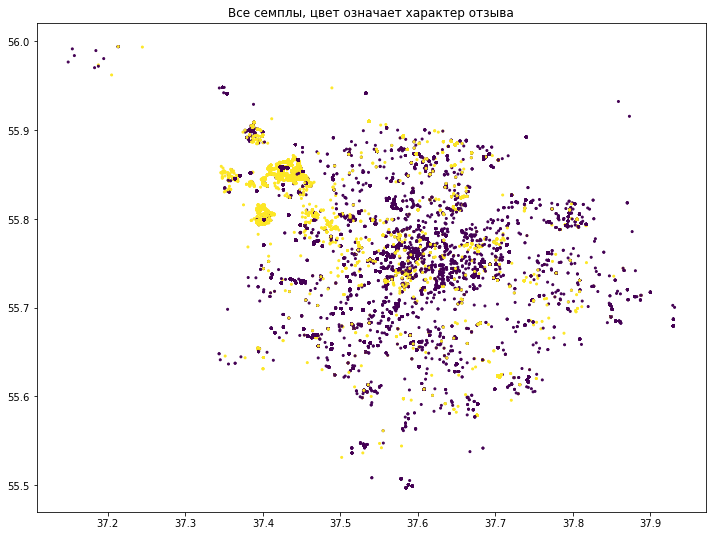

In [6]:
# отобразим графически семплы, цветом выделяя характер отзыва
plt.figure(figsize=(12, 9))
plt.title('Все семплы, цвет означает характер отзыва')
plt.scatter(df.x, df.y, c=df.comment_class, s=4)
plt.show()

#### Наблюдения по данным ####

- точки темного цвета - негативные отзывы, их подавляющее большинство
- положительные отзывы сосредоточены в северо-западной части города

Это, видимо, соответсвует объективной действительности: на северо-западе расположены такие районы Москвы, как Кунцево, Филёвский Парк, Крылатское, Строгино, Щукино, Покровское-Стрешнево и т.д. Эта часть города считается очень благоприятной для жизни.

### Кластеризация без учета отзывов ###

In [7]:
# нормализуем данные
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['x', 'y']] = scaler.fit_transform(df_scaled[['x', 'y']])
df_scaled.head()

,x,y,comment_class
0,0.367919,0.159553,-1
1,0.367919,0.159553,-1
2,0.293178,-0.348131,-1
3,-0.073819,-0.539880,-1
4,-0.009022,-0.496273,-1


In [8]:
# подготовим семплы для классификатора и найдем оптимальное число кластеров (приблизительно)
X_all = np.array(df_scaled[['x', 'y']])

# известно, что в Москве около 140-150 районов, поэтому рассмотрим диапазон значений от 50 до 150 с шагом 10
n_clusters_min, n_clusters_max, n_clusters_step = 50, 160, 10
n_clusters_possible_values = list(range(n_clusters_min, n_clusters_max, n_clusters_step))
n_clusters_optimal = get_kmeans_optimal_clusters_num(X_all, n_clusters_possible_values)
n_clusters_optimal

Trying number of clusters: 50
Trying number of clusters: 60
Trying number of clusters: 70
Trying number of clusters: 80
Trying number of clusters: 90
Trying number of clusters: 100
Trying number of clusters: 110
Trying number of clusters: 120
Trying number of clusters: 130
Trying number of clusters: 140
Trying number of clusters: 150
Optimal number of clusters: 60


60

In [9]:
# создадим модель для кластеризации на оптимальное число кластеров
model_all = KMeans(n_clusters=n_clusters_optimal)
y_all = model_all.fit_predict(X_all)

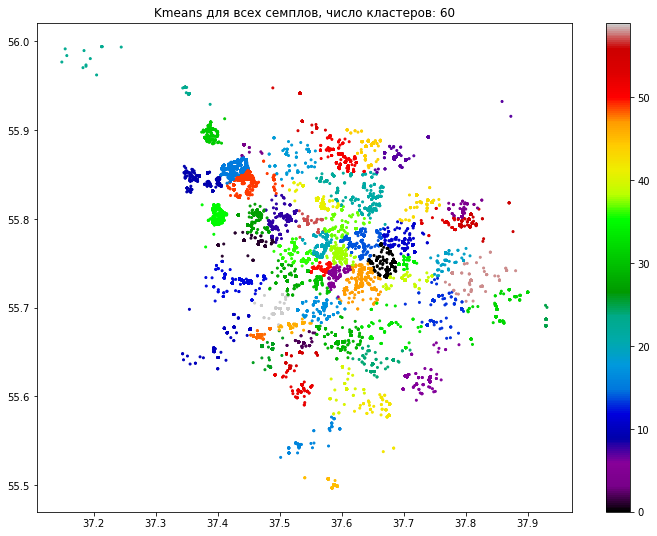

In [10]:
# отобразим результаты графически
plt.figure(figsize=(12, 9))
plt.title(f'Kmeans для всех семплов, число кластеров: {n_clusters_optimal}')
plt.scatter(df.x, df.y, c=y_all, s=4, cmap="nipy_spectral")
plt.colorbar()
plt.show()

### Кластеризация положительных и отрицательных отзывов ###

In [11]:
X_pos = np.array(df_scaled[df_scaled.comment_class == 1][['x', 'y']])
X_neg = np.array(df_scaled[df_scaled.comment_class == -1][['x', 'y']])

In [12]:
# для положительных и отрицательных отзывов оптимальное число кластеров может отличаться от общего, поэтому считаем отдельно
n_clusters_optimal_pos = get_kmeans_optimal_clusters_num(X_pos, n_clusters_possible_values)
n_clusters_optimal_neg = get_kmeans_optimal_clusters_num(X_neg, n_clusters_possible_values)

Trying number of clusters: 50
Trying number of clusters: 60
Trying number of clusters: 70
Trying number of clusters: 80
Trying number of clusters: 90
Trying number of clusters: 100
Trying number of clusters: 110
Trying number of clusters: 120
Trying number of clusters: 130
Trying number of clusters: 140
Trying number of clusters: 150
Optimal number of clusters: 70
Trying number of clusters: 50
Trying number of clusters: 60
Trying number of clusters: 70
Trying number of clusters: 80
Trying number of clusters: 90
Trying number of clusters: 100
Trying number of clusters: 110
Trying number of clusters: 120
Trying number of clusters: 130
Trying number of clusters: 140
Trying number of clusters: 150
Optimal number of clusters: 70


In [13]:
# создадим и обучим модели для работы с положительными и отрицательными отзывами
model_pos = KMeans(n_clusters=n_clusters_optimal_pos)
y_pos = model_pos.fit_predict(X_pos)
model_neg = KMeans(n_clusters=n_clusters_optimal_neg)
y_neg = model_neg.fit_predict(X_neg)

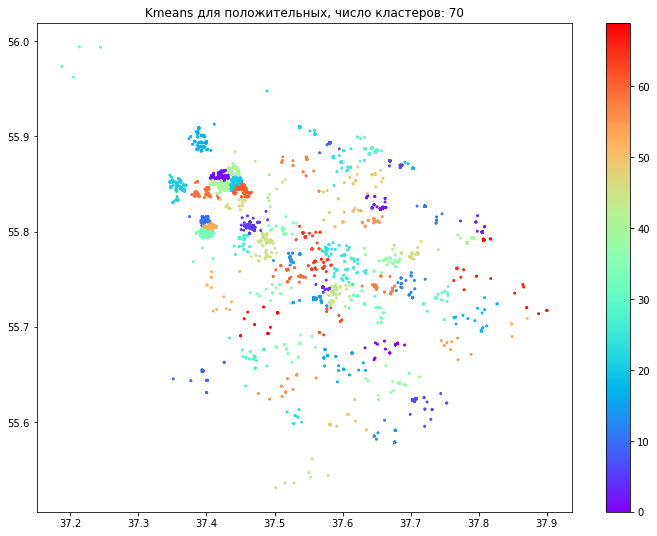

In [14]:
# отобразим результаты для положительных отзывов
plt.figure(figsize=(12, 9))
plt.title(f'Kmeans для положительных, число кластеров: {n_clusters_optimal_pos}')
plt.scatter(df[df.comment_class == 1].x, df[df.comment_class == 1].y, c=y_pos, s=4, cmap="rainbow")
plt.colorbar()
plt.show()

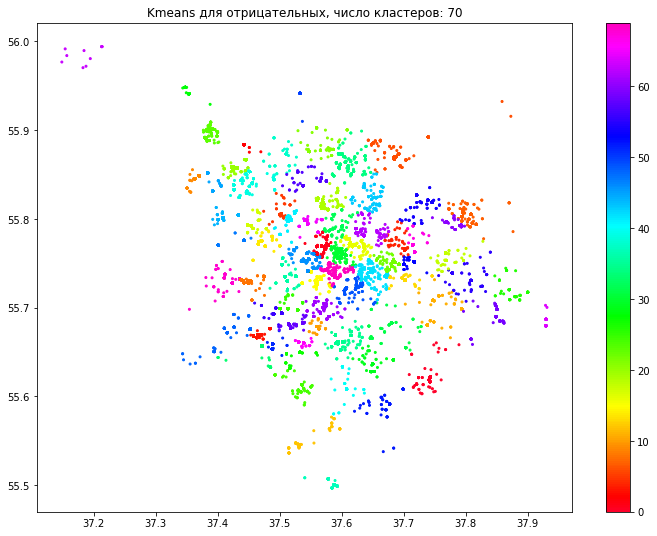

In [15]:
# отобразим результаты для отрицательных отзывов
plt.figure(figsize=(12, 9))
plt.title(f'Kmeans для отрицательных, число кластеров: {n_clusters_optimal_neg}')
plt.scatter(df[df.comment_class == -1].x, df[df.comment_class == -1].y, c=y_neg, s=4, cmap="gist_rainbow")
plt.colorbar()
plt.show()

### Оценка активности жителей в различных районах ###

- для оценки активности жителей по районам нужно отсортировать кластеры по убыванию количества отзывов в них
- после этого наглядно оценить активность можно будет при помощи цветовой схемы gray
- более темный цвет будет соответствовать большей активности, более светлый - меньшей

In [16]:
# для удобства добавим к оригинальному датасету номер кластера для каждого семпла, при этом характер отзыва можно убрать
df_clustered = df[['x', 'y']].copy()
df_clustered['cluster'] = y_all
df_clustered.head()

,x,y,cluster
0,37.612416,55.777454,14
1,37.612416,55.777454,14
2,37.603298,55.742108,5
3,37.558526,55.728758,30
4,37.566431,55.731794,30


In [17]:
# при помощи метода value_counts() получаем значения числа голосов в каждом кластере, отсортированные по убыванию
clusters = df_clustered.cluster.value_counts()
clusters

3     7346
48    6427
20    5455
0     5356
27    4996
38    4093
9     3875
15    3711
50    3436
34    3404
11    3384
4     3223
8     3159
56    3128
39    2966
26    2744
19    2587
12    2584
10    2154
30    2036
14    2015
1     1904
13    1769
37    1657
41    1567
59    1560
7     1522
46    1381
29    1316
28    1240
36    1214
55    1167
49    1137
6     1078
5      905
18     884
35     869
2      808
17     751
31     748
47     741
57     726
43     626
51     621
21     541
33     450
44     448
53     369
24     349
22     338
23     291
32     287
42     263
52     254
40     225
58     200
54     178
45     166
16     103
25      74
Name: cluster, dtype: int64

In [18]:
# перенумеруем кластеры по убыванию голосов и добавим столбец с новыми значениями кластеров для всех семплов
df_clustered['new_cluster'] = df_clustered['cluster'].apply(lambda c: clusters.index.get_loc(c))
df_clustered.head()

,x,y,cluster,new_cluster
0,37.612416,55.777454,14,20
1,37.612416,55.777454,14,20
2,37.603298,55.742108,5,34
3,37.558526,55.728758,30,19
4,37.566431,55.731794,30,19


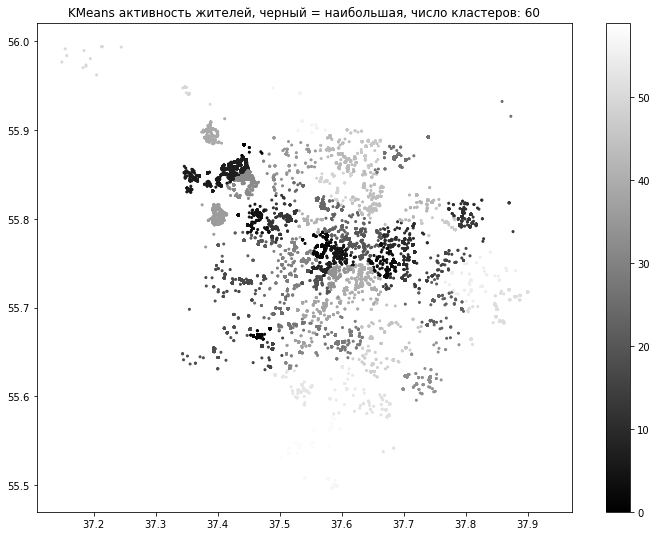

In [19]:
# Отобразим графически распределение по кластерам по убыванию числа семплов в них
plt.figure(figsize=(12, 9))
plt.title(f'KMeans активность жителей, черный = наибольшая, число кластеров: {clusters.size}')
plt.scatter(df_clustered.x, df_clustered.y, c=df_clustered.new_cluster, cmap='gray', s=4)
plt.colorbar()
plt.show()

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94
 95 96 97 98 99]


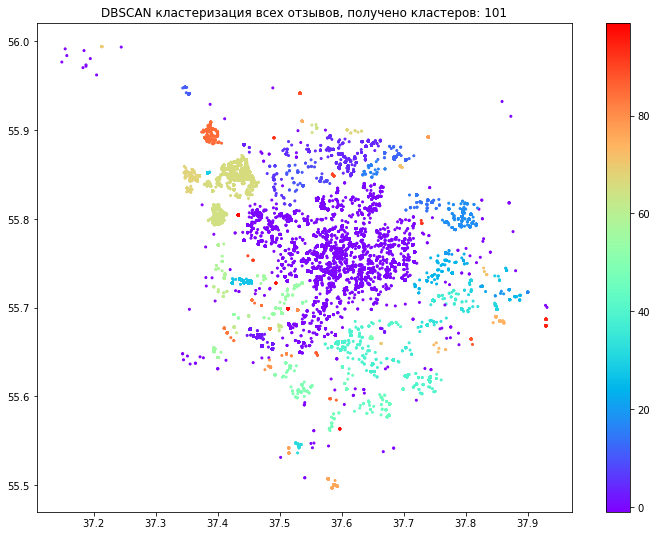

In [20]:
# в подсказке к заданию был упомянут метод DBSCAN, аналогично используем его для оценки активности
# сначала кластеризуем все семплы
model_all_dbscan = DBSCAN(eps=0.1)  # значение параметра было примерно подобрано экспериментально
y_all_dbscan = model_all_dbscan.fit_predict(X_all)
print(np.unique(model_all_dbscan.labels_))
plt.figure(figsize=(12, 9))
plt.title(f'DBSCAN кластеризация всех отзывов, получено кластеров: {np.unique(model_all_dbscan.labels_).size}')
plt.scatter(df.x, df.y, c=model_all_dbscan.labels_, s=4, cmap="rainbow")
plt.colorbar()
plt.show()

In [21]:
# исключим те семлы, которые DBSCAN отнес в категорию выбросов
df_dbscan = df[['x', 'y']].copy()
df_dbscan['cluster'] = model_all_dbscan.labels_
print(df_dbscan.shape)
df_dbscan = df_dbscan[df_dbscan.cluster != -1]
print(df_dbscan.shape)
df_dbscan.cluster.value_counts()

(108806, 3)
(108638, 3)


0     54429
2     11057
3      7341
18     6696
66     4942
20     2523
27     2183
68     2171
35     1596
29     1562
54     1505
12     1420
4      1239
40     1048
65      866
85      747
5       656
39      566
98      508
15      468
41      359
97      348
38      323
11      274
45      243
80      240
49      226
56      203
10      182
24      170
      ...  
72       16
48       15
61       15
43       15
52       15
53       14
84       14
67       13
1        12
23       11
9        10
63       10
60        9
86        9
22        9
7         8
92        7
28        7
91        7
26        7
57        7
87        7
71        6
99        6
70        6
96        6
73        6
69        5
93        5
19        5
Name: cluster, Length: 100, dtype: int64

In [22]:
# по аналогии с KMeans, добавляем столбец с новыми номерами кластеров, учитывающими число семплов в них
clusters_dbscan = df_dbscan.cluster.value_counts()
df_dbscan['new_cluster'] = df_dbscan['cluster'].apply(lambda c: clusters_dbscan.index.get_loc(c))
df_dbscan.tail()

,x,y,cluster,new_cluster
108801,37.454528,55.792331,0,0
108802,37.384325,55.899068,85,15
108803,37.421066,55.848756,66,4
108804,37.448509,55.793065,0,0
108805,37.451249,55.836620,66,4


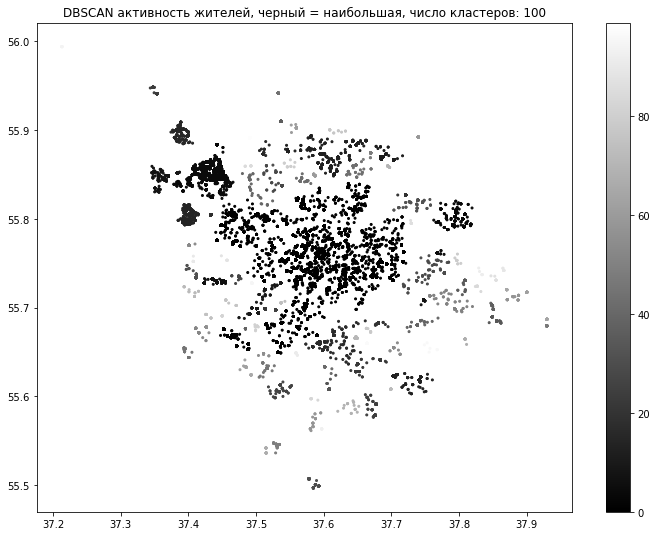

In [23]:
plt.figure(figsize=(12, 9))
plt.title(f'DBSCAN активность жителей, черный = наибольшая, число кластеров: {clusters_dbscan.size}')
plt.scatter(df_dbscan.x, df_dbscan.y, c=df_dbscan.new_cluster, s=4, cmap="gray")
plt.colorbar()
plt.show()

## Выводы по результатам ##

- жители Северо-Запада отличаются активностью в целом положительного характера
- жители центральных районов города активны и их отзывы по большей части отрицательны
- другие районы города отличаются меньшей активностью